# 公司研究

进行公司研究或竞争分析是任何商业战略的关键部分。在本笔记本中，我们将演示如何创建一个代理团队来处理这项任务。虽然有许多方法可以将任务转化为代理实现，但我们将探索一种顺序方法。我们将创建与研究过程步骤相对应的代理，并为它们提供执行任务的工具。

- **搜索代理**：搜索网络上有关公司的信息。将可以访问搜索引擎 API 工具来检索搜索结果。
- **股票分析代理**：从金融数据 API 检索公司的股票信息，计算基本统计数据（当前价格、52周高点、52周低点等），并生成年初至今的股票价格图表，将其保存到文件中。将可以访问金融数据 API 工具来检索股票信息。
- **报告代理**：根据搜索和股票分析代理收集的信息生成报告。

首先，让我们导入必要的模块。

In [1]:
from autogen_agentchat.agents import CodingAssistantAgent, ToolUseAssistantAgent
from autogen_agentchat.task import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_core.components.tools import FunctionTool
from autogen_ext.models import OpenAIChatCompletionClient

## 定义工具

接下来，我们将定义代理将用来执行任务的工具。我们将创建一个使用 Google 搜索 API 来搜索网络上有关公司信息的 `google_search`。我们还将创建一个使用 `yfinance` 库来检索公司股票信息的 `analyze_stock` 函数。

最后，我们将把这些函数封装到一个 `FunctionTool` 类中，这样我们就可以在代理中将它们用作工具。

注意：`google_search` 函数需要 API 密钥才能工作。您可以在与此笔记本相同的目录中创建一个 `.env` 文件，并添加您的 API 密钥：

```
GOOGLE_SEARCH_ENGINE_ID =xxx
GOOGLE_API_KEY=xxx 
```

同时安装所需的库：

```
pip install yfinance matplotlib pytz numpy pandas python-dotenv requests bs4
```

In [2]:
#!pip install yfinance matplotlib pytz numpy pandas python-dotenv requests bs4


def google_search(query: str, num_results: int = 2, max_chars: int = 500) -> list:  # type: ignore[type-arg]
    import os
    import time

    import requests
    from bs4 import BeautifulSoup
    from dotenv import load_dotenv

    load_dotenv()

    #api_key = os.getenv("GOOGLE_API_KEY")
    api_key = ""
    #search_engine_id = os.getenv("GOOGLE_SEARCH_ENGINE_ID")
    search_engine_id = ""

    if not api_key or not search_engine_id:
        raise ValueError("API key or Search Engine ID not found in environment variables")

    url = "https://www.googleapis.com/customsearch/v1"
    params = {"key": str(api_key), "cx": str(search_engine_id), "q": str(query), "num": str(num_results)}

    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(response.json())
        raise Exception(f"Error in API request: {response.status_code}")

    results = response.json().get("items", [])

    def get_page_content(url: str) -> str:
        try:
            response = requests.get(url, timeout=10)
            soup = BeautifulSoup(response.content, "html.parser")
            text = soup.get_text(separator=" ", strip=True)
            words = text.split()
            content = ""
            for word in words:
                if len(content) + len(word) + 1 > max_chars:
                    break
                content += " " + word
            return content.strip()
        except Exception as e:
            print(f"Error fetching {url}: {str(e)}")
            return ""

    enriched_results = []
    for item in results:
        body = get_page_content(item["link"])
        enriched_results.append(
            {"title": item["title"], "link": item["link"], "snippet": item["snippet"], "body": body}
        )
        time.sleep(1)  # Be respectful to the servers

    return enriched_results


def analyze_stock(ticker: str) -> dict:  # type: ignore[type-arg]
    import os
    from datetime import datetime, timedelta

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import yfinance as yf
    from pytz import timezone  # type: ignore

    stock = yf.Ticker(ticker)

    # Get historical data (1 year of data to ensure we have enough for 200-day MA)
    end_date = datetime.now(timezone("UTC"))
    start_date = end_date - timedelta(days=365)
    hist = stock.history(start=start_date, end=end_date)

    # Ensure we have data
    if hist.empty:
        return {"error": "No historical data available for the specified ticker."}

    # Compute basic statistics and additional metrics
    current_price = stock.info.get("currentPrice", hist["Close"].iloc[-1])
    year_high = stock.info.get("fiftyTwoWeekHigh", hist["High"].max())
    year_low = stock.info.get("fiftyTwoWeekLow", hist["Low"].min())

    # Calculate 50-day and 200-day moving averages
    ma_50 = hist["Close"].rolling(window=50).mean().iloc[-1]
    ma_200 = hist["Close"].rolling(window=200).mean().iloc[-1]

    # Calculate YTD price change and percent change
    ytd_start = datetime(end_date.year, 1, 1, tzinfo=timezone("UTC"))
    ytd_data = hist.loc[ytd_start:]  # type: ignore[misc]
    if not ytd_data.empty:
        price_change = ytd_data["Close"].iloc[-1] - ytd_data["Close"].iloc[0]
        percent_change = (price_change / ytd_data["Close"].iloc[0]) * 100
    else:
        price_change = percent_change = np.nan

    # Determine trend
    if pd.notna(ma_50) and pd.notna(ma_200):
        if ma_50 > ma_200:
            trend = "Upward"
        elif ma_50 < ma_200:
            trend = "Downward"
        else:
            trend = "Neutral"
    else:
        trend = "Insufficient data for trend analysis"

    # Calculate volatility (standard deviation of daily returns)
    daily_returns = hist["Close"].pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252)  # Annualized volatility

    # Create result dictionary
    result = {
        "ticker": ticker,
        "current_price": current_price,
        "52_week_high": year_high,
        "52_week_low": year_low,
        "50_day_ma": ma_50,
        "200_day_ma": ma_200,
        "ytd_price_change": price_change,
        "ytd_percent_change": percent_change,
        "trend": trend,
        "volatility": volatility,
    }

    # Convert numpy types to Python native types for better JSON serialization
    for key, value in result.items():
        if isinstance(value, np.generic):
            result[key] = value.item()

    # Generate plot
    plt.figure(figsize=(12, 6))
    plt.plot(hist.index, hist["Close"], label="Close Price")
    plt.plot(hist.index, hist["Close"].rolling(window=50).mean(), label="50-day MA")
    plt.plot(hist.index, hist["Close"].rolling(window=200).mean(), label="200-day MA")
    plt.title(f"{ticker} Stock Price (Past Year)")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)

    # Save plot to file
    os.makedirs("coding", exist_ok=True)
    plot_file_path = f"coding/{ticker}_stockprice.png"
    plt.savefig(plot_file_path)
    print(f"Plot saved as {plot_file_path}")
    result["plot_file_path"] = plot_file_path

    return result

In [3]:
google_search_tool = FunctionTool(
    google_search, description="Search Google for information, returns results with a snippet and body content"
)
stock_analysis_tool = FunctionTool(analyze_stock, description="Analyze stock data and generate a plot")

## 定义代理

接下来，我们将定义执行任务的代理。我们将创建一个搜索网络上公司信息的 `search_agent`，一个检索公司股票信息的 `stock_analysis_agent`，以及一个根据其他代理收集的信息生成报告的 `report_agent`。

In [5]:
model_client = OpenAIChatCompletionClient(
    model="gpt-4o",
    temperature=1,
    api_key="sk-", # Optional if you have an OPENAI_API_KEY env variable set.
)

search_agent = ToolUseAssistantAgent(
    name="Google_Search_Agent",
    model_client=model_client,
    registered_tools=[google_search_tool],
    description="Search Google for information, returns top 2 results with a snippet and body content",
    system_message="You are a helpful AI assistant. Solve tasks using your tools.",
)

stock_analysis_agent = ToolUseAssistantAgent(
    name="Stock_Analysis_Agent",
    model_client=model_client,
    registered_tools=[stock_analysis_tool],
    description="Analyze stock data and generate a plot",
    system_message="You are a helpful AI assistant. Solve tasks using your tools.",
)

report_agent = CodingAssistantAgent(
    name="Report_Agent",
    model_client=model_client,
    description="Generate a report based on the search and stock analysis results",
    system_message="You are a helpful assistant that can generate a comprehensive report on a given topic based on search and stock analysis. When you done with generating the report, reply with TERMINATE.",
)

termination = TextMentionTermination("TERMINATE")
team = RoundRobinGroupChat([search_agent, stock_analysis_agent, report_agent], termination_condition=termination)

/tmp/ipykernel_5163/3594775254.py:7: DeprecationWarning: ToolUseAssistantAgent is deprecated. Use AssistantAgent instead.
  search_agent = ToolUseAssistantAgent(
/tmp/ipykernel_5163/3594775254.py:15: DeprecationWarning: ToolUseAssistantAgent is deprecated. Use AssistantAgent instead.
  stock_analysis_agent = ToolUseAssistantAgent(
/tmp/ipykernel_5163/3594775254.py:23: DeprecationWarning: CodingAssistantAgent is deprecated. Use AssistantAgent instead.
  report_agent = CodingAssistantAgent(


Plot saved as coding/AAL_stockprice.png
TaskResult(messages=[TextMessage(source='user', models_usage=None, content='Write a financial report on American airlines'), ToolCallMessage(source='Google_Search_Agent', models_usage=RequestUsage(prompt_tokens=116, completion_tokens=25), content=[FunctionCall(id='call_t45Va8kGOoTp7x6mqrw9pyK1', arguments='{"query":"American Airlines financial report 2023","num_results":3}', name='google_search')]), ToolCallResultMessage(source='Google_Search_Agent', models_usage=None, content=[FunctionExecutionResult(content="[{'title': 'American Airlines reports fourth-quarter and full-year 2023 financial ...', 'link': 'https://news.aa.com/news/news-details/2024/American-Airlines-reports-fourth-quarter-and-full-year-2023-financial-results-CORP-FI-01/default.aspx', 'snippet': 'Jan 25, 2024 ... American Airlines Group Inc. (NASDAQ: AAL) today reported its fourth-quarter and full-year 2023 financial results, including: Record\\xa0...', 'body': 'Just a moment... En

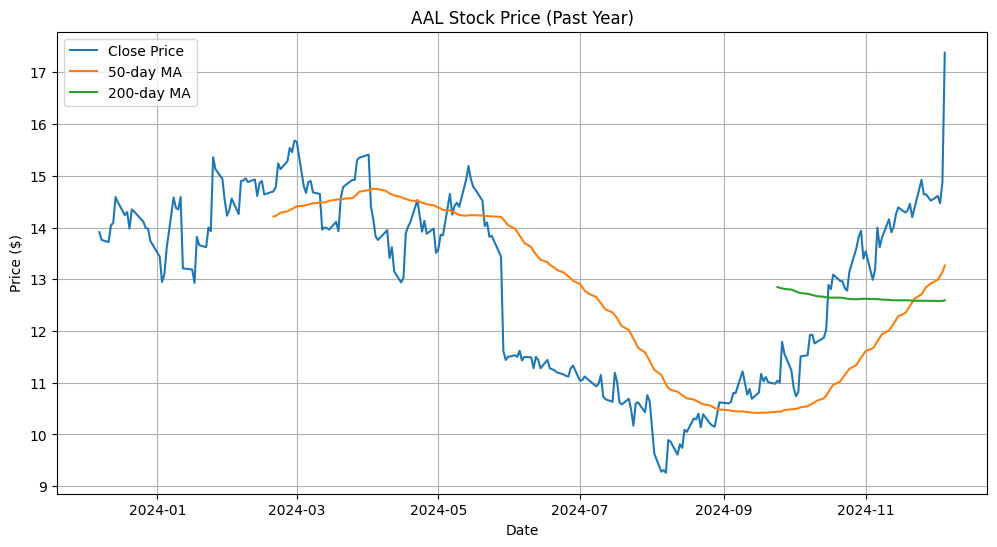

In [6]:
result = await team.run(task="Write a financial report on American airlines")
print(result)